# One-dimensional stationary diffusion equation

This lab differs from the previous one only in that here we carefully study the monotonicity of our difference scheme. But in general, this lab is a prologue to the solution of non-stationary and multidimensional transport equations in partial derivatives.

$$-\frac{d}{dx}(k(x)\frac{d}{dx}y(x)) + v(x)\frac{d}{dx}y(x) = f(x)$$
in interval [a, b]

In [432]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.patches as patches
import numpy as np
import math
import random
import scipy.optimize
from scipy.optimize import least_squares

In [468]:
# -(k(x)y')' + u(x)y' = f(x)
# y = sin(x)

y_real = lambda x: -x**4 + 0.1 * x**3 + 3.1 * x**2 - 2.2 * x
k = lambda x: 1
v = lambda x: np.exp(10*x) - 10
f = lambda x: (-12*x**2 + 0.6*x + 6.2) + v(x) * (-4*x**3 + 0.3*x**2 + 6.2*x - 2.2)

# 0 < x < pi
h = 0.01
a = 0
b = 1
YaTrue = 0
YbTrue = 0

# y_real = lambda x: -np.sin(x)
# k = lambda x: 1
# v = lambda x: -x
# f = lambda x: +x*np.cos(x) + np.sin(x)

# h = 0.08
# a = 0
# b = np.pi
# YaTrue = 0
# YbTrue = 0

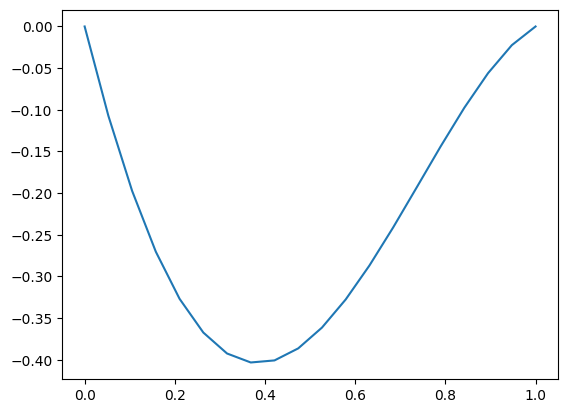

In [469]:
xs = np.linspace(a, b, 20)
plt.plot(xs, y_real(xs))

## Finite Volume Approximation with Second Order

We have a recursive formula:
$$
A_i * Y_{i+1} + B_i * Y_i + C_i * Y_{i-1} = D_i\\
\\
A_{i} = \frac{k_{i+0.5}}{h^2} + \frac{V_{i-0.5}}{2h}\\
B_{i} = \frac{V_{i+0.5}}{2h} - \frac{2k_{i}}{h^2}\\
C_{i} = \frac{k_{i-0.5}}{h^2} - \frac{V_{i+0.5}}{2h}\\
\\
Y_{0} = 0\\
Y_{N} = 0\\
$$

>$MAT_{(N+2, N+1)} \;\;\;= \begin{bmatrix} 
1   & 0   & ... & ... & ...     & 0   \\ 
C_1 & B_1 & A_1 & ... & ...     & 0   \\ 
... & ... & ... & ... & ...     & ... \\
... & ... & ... & ... & A_{N-1} & 0   \\
0   & ... & ,.. & C_N & B_N     & A_N \\
0   & 0   & ... & ... & ...     & 1   \\ 
\end{bmatrix}
$

>$VEC_{(N+2,1)} \;\;\;= \begin{bmatrix} 
0  \\ 
D_1\\ 
...\\
...\\
D_N\\
0  \\
\end{bmatrix}
$


We find the roots of the tridiagonal matrix of such a system. We estimate the [Peclet Numbers](https://ru.wikipedia.org/wiki/%D0%A7%D0%B8%D1%81%D0%BB%D0%BE_%D0%9F%D0%B5%D0%BA%D0%BB%D0%B5) at each node:
       
$$PE_i = \frac{V_i * h}{K_i}$$

In [554]:
def gridMethodLinear(a, b, YaTrue, YbTrue, h, p, q, f):
    N = int((b - a) / h)
    
    xs = np.arange(a, b, h)
    xs = np.append(xs, 1)
    
    A = [1/h**2 + p(xs[i]) / (2*h)  for i in range(N)]
    B = [-2/h**2 + q(xs[i]) for i in range(N)]
    C = [1/h**2 - p(xs[i]) / (2*h) for i in range(N)]
    D = [f(xs[i]) for i in range(N)]
    
    MAT = []
    VEC = []
    
    MAT.append([0 for i in range(N+1)])
    MAT[0][0] = 1
    VEC.append(YaTrue)
    
    for i in range(1, N):
        ADD = [0 for i in range(N+1)]
        ADD[i - 1] = C[i]
        ADD[i] = B[i]
        ADD[i + 1] = A[i]
        MAT.append(ADD)
        VEC.append(D[i])
        
    MAT.append([0 for i in range(N+1)])
    MAT[-1][-1] = 1
    VEC.append(YbTrue)
    
    sweep(MAT, VEC)
    
    ys = np.array(VEC)
    
    return xs, ys



def sweep(A, b):
    n = len(b)
    y = [0 for row in range(n)]
    alpha = [0 for row in range(n)]
    beta = [0 for row in range(n)]
    
    if A[0][0] == 0:
        return 0
    
    y[0]     = A[0][0]
    alpha[0] = -A[0][1] / y[0]
    beta[0]  = b[0] / y[0]
    
    # forward
    for i in range(1, n):
        y[i] = A[i][i] + alpha[i-1] * A[i][i-1]
        
        if y[i] == 0:
            return 0
        
        if i < n - 1:
            alpha[i] = -A[i][i+1] / y[i]
        beta[i] = (b[i] - A[i][i-1]*beta[i-1])/y[i]
        
    # backward and result
    b[n-1] = beta[n-1]
    
    for i in range(n-2, -1, -1):
        b[i] = alpha[i] * b[i+1] + beta[i]
    return 1


def FVA(k, V, f, h):
    
    xs = np.arange(a, b, h)
    xs = np.append(xs, b)
    N = len(xs) - 1
    
    def V_(i, half):
        if half == 0.5:
            return V((xs[i + 1] + xs[i])/2) 
        if half == 0:
            return V(xs[i])
        if half == -0.5:
            return V((xs[i-1] + xs[i])/2)
        
    def K_ (i, half):
        if half == 0.5:
            return k((xs[i + 1] + xs[i])/2) 
        if half == 0:
            return k(xs[i])
        if half == -0.5:
            return k((xs[i-1] + xs[i])/2)
    
    A = [(K_(i, -0.5)/h**2 + V_(i, -0.5)/(2*h))                     for i in range(N)]
    B = [-( 2*K_(i, 0)/h**2 - V_(i, 0.5)/(2*h) + V_(i, -0.5)/(2*h)) for i in range(N)]
    C = [-(V_(i, 0.5) / (2 * h) - K_(i, 0.5)/h**2)                  for i in range(N)]
    D = [f(xs[i])                                                   for i in range(N)]
    
    MAT = []
    VEC = []
    
    MAT.append([0 for i in range(N+1)])
    MAT[0][0] = 1
    VEC.append(0)
    
    for i in range(1, N):
        ADD = [0 for i in range(N+1)]
        ADD[i - 1] = C[i]
        ADD[i] = B[i]
        ADD[i + 1] = A[i]
        MAT.append(ADD)
        
        VEC.append(D[i])
        
    MAT.append([0 for i in range(N+1)])
    MAT[-1][-1] = 1
    VEC.append(0)
    
    sweep(MAT, VEC)
    
    ys = np.array(VEC)
    
    return xs, ys, [V_(i, 0) * h / K_(i, 0) for i in range(0, N+1)]

In [496]:
def makeGraph(func, k, V, f, h,func_real):
    xs, ys, Pe = func(k, v, f, h)
    print(len(xs))

    fig, axs = plt.subplots(2)

    axs[1].scatter(xs[::3], Pe[::3], label = "Peclet")
    i0 = 0
    for i in range(len(xs)):
        if (Pe[i] > 2):
            i0 = i
            break
    
    axs[1].scatter(xs[i0], Pe[i0])

    axs[0].scatter(xs[i0], ys[i0])    

    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    axs[1].set_xlabel("x")
    axs[1].set_ylabel("Pe")

    axs[0].plot(xs, ys, label = "solution")

    

    axs[0].plot(xs, func_real(xs), '--', label = "true")

    axs[0].legend()
    axs[1].legend()
    plt.show()


101


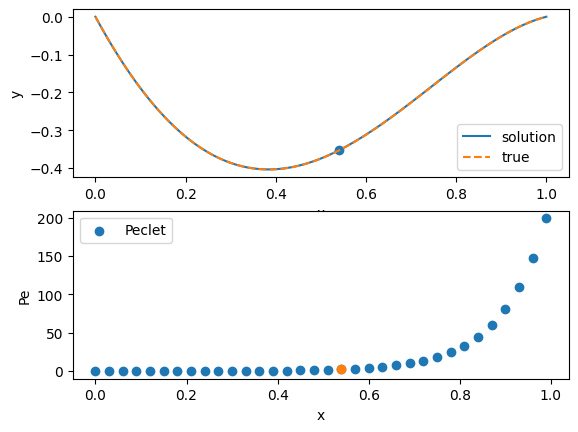

In [497]:
makeGraph(FVA, k, v, f, h, y_real)

## Monotonized scheme
For monotonized function Peclie Number < 2
Our monotonicity criterion looks like this:
$$Pe < 2$$

Let's replace K so that it always does. Let:
$$k_{new} = k_{old} * (1 + r)$$

Then:
$$\frac{Vh}{2k} - 1 = r$$

Let's replace K with a new one. And we get:

In [482]:
def monotonizedScheme(k, V, f, h):
    
    xs = np.arange(a, b, h)
    xs = np.append(xs, b)
    N = len(xs) - 1
    
    def V_(i, half):
        if half == 0.5:
            return V((xs[i + 1] + xs[i])/2) 
        if half == 0:
            return V(xs[i])
        if half == -0.5:
            return V((xs[i-1] + xs[i])/2)
    # For what
    def k_(i):
        ro = max(0, V(xs[i]) * h / (2 * k(xs[i])) - 1 + 0.01)
        return k(xs[i]) * (1 + ro)
    
    A = [(k_(i)/h**2 + V_(i, -0.5)/(2*h)) for i in range(N)]
    B = [-( 2*k_(i)/h**2 - V_(i, 0.5)/(2*h) + V_(i, -0.5)/(2*h)) for i in range(N)]
    C = [-(V_(i, 0.5) / (2 * h) - k_(i)/h**2)  for i in range(N)]
    D = [f(xs[i]) for i in range(N)]
    
    Pe = np.array([V_(i, 0) * h / k_(i) for i in range(0, N+1)])
    
    MAT = []
    VEC = []
    
    MAT.append([0 for i in range(N+1)])
    MAT[0][0] = 1
    VEC.append(0)
    
    for i in range(1, N):
        ADD = [0 for i in range(N+1)]
        ADD[i - 1] = C[i]
        ADD[i] = B[i]
        ADD[i + 1] = A[i]
        MAT.append(ADD)
        VEC.append(D[i])
        
    MAT.append([0 for i in range(N+1)])
    MAT[-1][-1] = 1
    VEC.append(0)
    
    sweep(MAT, VEC)
    
    ys = np.array(VEC)

    return xs, ys, Pe

In [483]:
def makeGraph2(func, h):
    xs, ys, Pe = func(k, v, f, h)


    fig, axs = plt.subplots(2)

    axs[1].plot(xs, Pe, label = "Peclet")
    i0 = 0
    for i in range(len(xs)):
        if (Pe[i] > 2):
            i0 = i
            break
    
    #axs[1].scatter(xs[i0], Pe[i0])

    #axs[0].scatter(xs[i0], ys[i0])    

    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    axs[1].set_xlabel("x")
    axs[1].set_ylabel("Pe")

    axs[0].plot(xs, ys, label = "solution")


    axs[0].plot(xs, y_real(xs), '--', label = "true")

    axs[0].legend()
    axs[1].legend()
    plt.show()

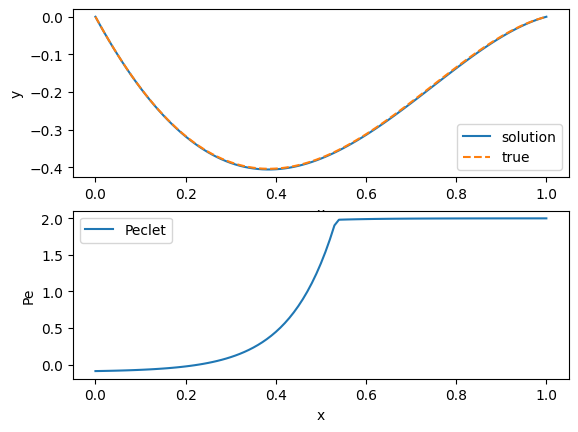

In [484]:
makeGraph2(monotonizedScheme, h)


Now the monotonicity criterion is always satisfied. And the graph looks better.

## Unconditionally monotonic scheme
In operator form, the task was written as follows:
$$D[y] + C[y] = f$$


$$
D[y] = k\frac{d^2}{dx^2}y\\
C[y] = V(x)\frac{dy}{dx}
$$

Accordingly, these operators are given grid analogues. (pure derivatives are approximated and obtained) But this approach does not guarantee monotonicity. Therefore, we define the grid operator C like this:

$$C[Y]_i = \frac{1}{h}*(V^{+}_{i+0.5}*Y_i + V^{-}_{i+0.5}*Y_{i+1} - V^{+}_{i-0.5}*Y_{i-1} - V^{-}_{i-0.5}*Y_i)$$

$$
V^{+}_i = 0.5*(V_i + |V_i|)\\
V^{-}_i = 0.5*(V_i - |V_i|)
$$

### As a result, the recursive equation will be:
$$Y_{i+1}*(\frac{-k}{h^2} + \frac{V^{-}_{i+0.5}}{h}) + Y_i * (\frac{2k}{h^2} + \frac{V^{+}_{i+0.5}}{h} - \frac{V^{-}_{i-0.5}}{h}) + Y_{i-1}*(\frac{-k}{h^2} - \frac{V^{+}_{i-0.5}}{h}) = f_i$$

In [552]:
def DMS(k, V, f, h, z):
    
    xs = np.arange(a, b, h)
    xs = np.append(xs, b)
    N = len(xs) - 1

    
    def V_(i, half):
        if half == 0.5:
            return (V(xs[i + 1]) + V(xs[i]))/2
        if half == 0:
            return V(xs[i])
        if half == -0.5:
            return (V(xs[i-1]) + V(xs[i]))/2
    
    def VP(i, half):
        return 0.5 * (V_(i, half) + math.fabs(V_(i, half)))
    
    def VM(i, half):
        return 0.5 * (V_(i, half) - math.fabs(V_(i, half)))
    
        
#     A = [(K_(i, -0.5)/h**2 + V_(i, -0.5)/(2*h))                     for i in range(N)]
#     B = [-( 2*K_(i, 0)/h**2 - V_(i, 0.5)/(2*h) + V_(i, -0.5)/(2*h)) for i in range(N)]
#     C = [-(V_(i, 0.5) / (2 * h) - K_(i, 0.5)/h**2)                  for i in range(N)]
#     D = [f(xs[i])                                                   for i in range(N)]
   
    
    A = [-(-z[0]*VP(i, -0.5) / h - z[1]*k(xs[i])/h**2)  for i in range(N)]
    B = [-(z[2]*2*k(xs[i])/h**2 + z[3]*VP(i, 0.5)/h - z[4]*VM(i, -0.5)/h) for i in range(N)]
    C = [-(-z[5]*k(xs[i])/h**2 + z[6]*VM(i, 0.5)/h) for i in range(N)]
    D = [f(xs[i]) for i in range(N)]
    
    MAT = []
    VEC = []
    
    MAT.append([0 for i in range(N+1)])
    MAT[0][0] = 1
    VEC.append(0)
    
    for i in range(1, N):
        ADD = [0 for i in range(N+1)]
        ADD[i - 1] = C[i]
        ADD[i] = B[i]
        ADD[i + 1] = A[i]
        MAT.append(ADD)
        VEC.append(D[i])
        
    MAT.append([0 for i in range(N+1)])
    MAT[-1][-1] = 1
    VEC.append(0)
    
    sweep(MAT, VEC)
    
    ys = np.array(VEC)

    return xs, ys, [V_(i, 0) * h / k(xs[i]) for i in range(0, N+1)]

def v1(x):
    return 1

def f1(x):
    return -math.pi**2 * math.sin(math.pi * x) + math.pi * V(x) * math.cos(math.pi * x)

def makeGraph3(func, h, z):
    xs, ys, Pe = func(k, v1, f1, h, z)


    fig, ax = plt.subplots(1)

    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax.plot(xs, ys, label = "solution")
    
    xs, ys = gridMethodLinear(0, 1, 0, 0, h, v1, lambda x: 0, f1)
    ax.plot(xs, ys, '--', label = "true")

    ax.legend()

    plt.show()

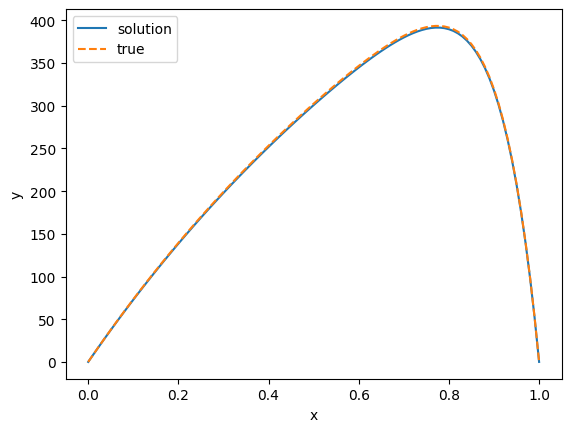

In [553]:
z = [1, 1, 1, 1, 1, 1, 1]
makeGraph3(DMS, h, z)

In [543]:
2**7

128

In [ ]:
[1, 1, 1, -1, 1, 1, -1]

In [561]:
def calcInfl(h, func, VV, ff, met):
    err = 0
    xs, ys, Pe = met(k, VV, ff, h)
    for i in range(0, min(len(xs), len(ys))):
        err = max(err, math.fabs(func(xs[i]) - ys[i]))
    return err

def calcInfl_(h):
    err = 0
    xs, ys, Pe = DMS(k, V1, f1, h, [1, 1, 1, 1, 1, 1, 1])
    xs1, ys1 = gridMethodLinear(0, 1, 0, 0, h, V1, lambda x: 0, f1)
    for i in range(0, min(len(ys1), len(ys))):
        err = max(err, math.fabs(ys1[i] - ys[i]))
    return err

def trueF(x):
    return math.sin(math.pi * x)

def check(xs, arr):
    res = []
    xs_res = []
    for i in range(1, len(arr) - 1):
        if (arr[i-1] > arr[i] and arr[i+1] > arr[i]):
            res.append(2*xs[i])
            xs_res.append(xs[i])
    return np.array(xs_res), np.array(res)

def drawInfl():
    hs = np.arange(0.004, 0.014, 0.0001)
    
    infls1 = []
    infls2 = []
    infls3 = []
    
    for h in hs:
        infl1 = calcInfl(h, trueF, v, f, FVA)
        infl2 = calcInfl(h, trueF, v, f, monotonizedScheme)
        infl3 = calcInfl_(h)
        
        infls1.append(infl1)
        infls2.append(infl2)
        infls3.append(infl3)
        
    fig, ax = plt.subplots()
    
    infls1 = np.array(infls1)
    infls2 = np.array(infls2)
    infls3 = np.array(infls3)
    
    hs = np.array([math.log(h) for h in hs])
    infls1 = np.array([math.log(infl) for infl in infls1])
    infls2 = np.array([math.log(infl) for infl in infls2])
    infls3 = np.array([math.log(infl) for infl in infls3])
    
    xs1, infls1 = check(hs, infls1)
    xs2, infls2 = check(hs, infls2)
    
    k1 = (infls1[-1] - infls1[0]) / (xs1[-1] - xs1[0])
    k2 = (infls2[-1] - infls2[0]) / (xs2[-1] - xs2[0])
    k3 = (infls3[-1] - infls3[1]) / (hs[-1] - hs[0])
    
    print(round(k1))
    print(round(k2))
    print(round(k3))
    
    ax.plot(xs1, infls1, label = "FVA")
    ax.plot(xs2, infls2, label = "monotonized")
    ax.plot(hs, infls3, '--', label = "DMS")

    ax.legend()

    plt.show()

2
2
1


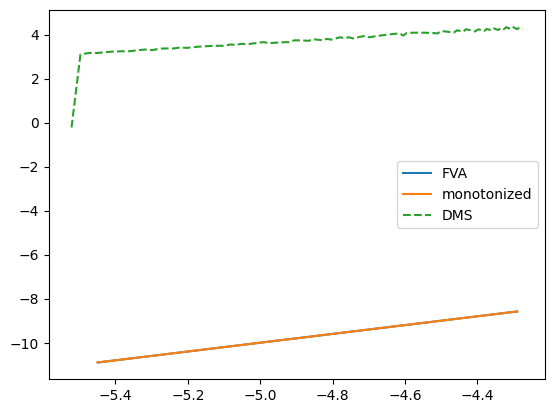

In [562]:
drawInfl()

| Finite volume approximation | Monotonized scheme | Unconditionally monotonic scheme |
|---------------------------------|---------------------- ---|------------------------------------|
| 2 | 2 | 1 |